In [11]:
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics, svm
from math import sqrt
from sklearn.metrics import r2_score
%matplotlib inline
import xgboost as xgb

In [2]:
train = pd.read_csv('c:/Users/joe/desktop/train_2016_v2.csv',parse_dates=['transactiondate'])

# load the properties data
prp = pd.read_csv('c:/Users/joe/desktop/properties_2016.csv')

merged = pd.merge(train,prp,on='parcelid',how='left')

# Linear Variable Combinations
merged['property_age'] = 2018 - merged['yearbuilt']
merged['total_rooms'] = merged['calculatedbathnbr'] + merged['bedroomcnt']
merged['garage_yn'] = np.where((merged['garagecarcnt'] > 0) | (merged['garagetotalsqft'] > 0),1,0)
merged['prop_to_land'] = merged['structuretaxvaluedollarcnt']/merged['landtaxvaluedollarcnt']
merged['length_tax_delinq'] = 2018 - merged['taxdelinquencyyear']
merged['coords'] = merged['latitude']/(10^6) + merged['longitude']/(10^6)
zip_count = merged['regionidzip'].value_counts().to_dict()
merged['zip_counts'] = merged['regionidzip'].map(zip_count)
city_count = merged['regionidcity'].value_counts().to_dict()
merged['city_counts'] = merged['regionidcity'].map(city_count)
county_count = merged['regionidcounty'].value_counts().to_dict()
merged['county_counts'] = merged['regionidcounty'].map(county_count)
merged['ac_yn'] = (merged['airconditioningtypeid']!=5)*1
merged['heat_yn'] = (merged['heatingorsystemtypeid']!=13)*1
merged['property_type'] = merged.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 
# structuretaxvaluedollarcnt by city
group = merged.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merged['stvdc_avg_bycity'] = merged['regionidcity'].map(group)
merged['stvdc_avg_dev'] = abs((merged['structuretaxvaluedollarcnt'] - merged['stvdc_avg_bycity']))/merged['stvdc_avg_bycity']


C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
high = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),99)
low = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),1)
mor = merged[(np.log(merged['taxvaluedollarcnt']) > low) & (np.log(merged['taxvaluedollarcnt']) < high)]

In [4]:
#%%
# Random Forest Without Multicollinearity <200k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[data['taxvaluedollarcnt']<200000]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_200,xtest_200,ytrain_200,ytest_200 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_200 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_200.fit(xtrain_200,ytrain_200)
print("Random Forest MSE:",np.mean(grid_200.predict(xtest_200)-ytest_200)**2)
print("Random Forest MAE:",np.mean(np.abs(grid_200.predict(xtest_200)-ytest_200)))
print("Random Forest RMSE:",sqrt(np.mean(grid_200.predict(xtest_200)-ytest_200)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Random Forest MSE: 7097.869622973272
Random Forest MAE: 5822.1639517141475
Random Forest RMSE: 84.24885532144204


R2: 0.9288


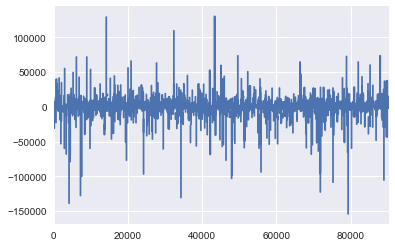

In [7]:
r2 = r2_score(ytest_200, grid_200.predict(xtest_200))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_200.predict(xtest_200)-ytest_200

data1['pred_diff'].plot()

In [8]:
# Random Forest Without Multicollinearity 200k > x > 350k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=200000) & (data['taxvaluedollarcnt']<350000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_350,xtest_350,ytrain_350,ytest_350 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_350 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_350.fit(xtrain_350,ytrain_350)
print("Random Forest MSE:",np.mean(grid_350.predict(xtest_350)-ytest_350)**2)
print("Random Forest MAE:",np.mean(np.abs(grid_350.predict(xtest_350)-ytest_350)))
print("Random Forest RMSE:",sqrt(np.mean(grid_350.predict(xtest_350)-ytest_350)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Random Forest MSE: 40884.20141021001
Random Forest MAE: 13976.184102706664
Random Forest RMSE: 202.19842088950648


R2: 0.7742


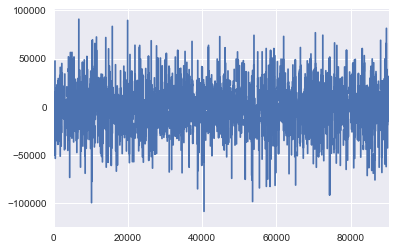

In [9]:
r2 = r2_score(ytest_350, grid_350.predict(xtest_350))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_350.predict(xtest_350)-ytest_350

data1['pred_diff'].plot()

In [10]:
# Random Forest Without Multicollinearity 350k > x > 500k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=350000) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_500,xtest_500,ytrain_500,ytest_500 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[1000], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_500 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_500.fit(xtrain_500,ytrain_500)
print("Random Forest MSE:",np.mean(grid_500.predict(xtest_500)-ytest_500)**2)
print("Random Forest MAE:",np.mean(np.abs(grid_500.predict(xtest_500)-ytest_500)))
print("Random Forest RMSE:",sqrt(np.mean(grid_500.predict(xtest_500)-ytest_500)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Random Forest MSE: 12245.198081771796
Random Forest MAE: 19665.994724505064
Random Forest RMSE: 110.65802312427145


R2: 0.6297


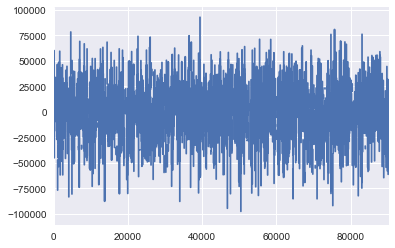

In [12]:
r2 = r2_score(ytest_500, grid_500.predict(xtest_500))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_500.predict(xtest_500)-ytest_500

data1['pred_diff'].plot()

In [13]:
# Random Forest Without Multicollinearity 500k > x > 1MM
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=500000) & (data['taxvaluedollarcnt']<1000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_1000,xtest_1000,ytrain_1000,ytest_1000 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_1000 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_1000.fit(xtrain_1000,ytrain_1000)
print("Random Forest MSE:",np.mean(grid_1000.predict(xtest_1000)-ytest_1000)**2)
print("Random Forest MAE:",np.mean(np.abs(grid_1000.predict(xtest_1000)-ytest_1000)))
print("Random Forest RMSE:",sqrt(np.mean(grid_1000.predict(xtest_1000)-ytest_1000)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Random Forest MSE: 1458163.1944772033
Random Forest MAE: 50931.90478256387
Random Forest RMSE: 1207.5442826154258


R2: 0.7131


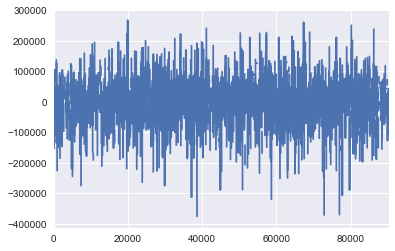

In [16]:
from sklearn.metrics import r2_score
r2 = r2_score(ytest_1000, grid_1000.predict(xtest_1000))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid_1000.predict(xtest_1000)-ytest_1000

data1['pred_diff'].plot()

In [19]:
# Random Forest Without Multicollinearity 1MM > x > 10MM
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=1000000) & (data['taxvaluedollarcnt']<10000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_10000,xtest_10000,ytrain_10000,ytest_10000 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], 'min_samples_leaf':[1],
               'max_features':['auto', 'sqrt']}
model = RandomForestRegressor()
grid_10000 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_10000.fit(xtrain_10000,ytrain_10000)
print("Random Forest MSE:",np.mean(grid_10000.predict(xtest_10000)-ytest_10000)**2)
print("Random Forest MAE:",np.mean(np.abs(grid_10000.predict(xtest_10000)-ytest_10000)))
print("Random Forest RMSE:",sqrt(np.mean(grid_10000.predict(xtest_10000)-ytest_10000)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Random Forest MSE: 9801.05000006366
Random Forest MAE: 119406.4721335576
Random Forest RMSE: 99.00025252525198


R2: 0.7613


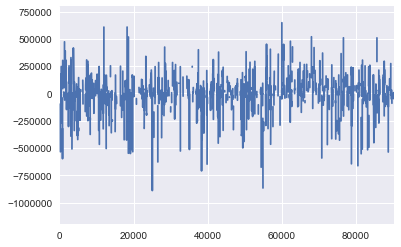

In [20]:
r2 = r2_score(ytest_10000, grid_10000.predict(xtest_10000))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid_10000.predict(xtest_10000)-ytest_10000

data1['pred_diff'].plot()

In [30]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=500000) & (data['taxvaluedollarcnt']<10000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 81274.65831056466


R2: 0.8739


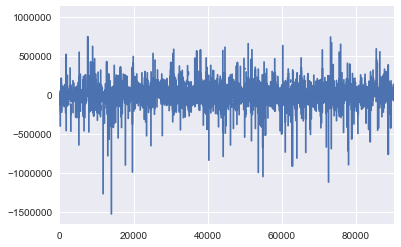

In [31]:
r2 = r2_score(ytest, model.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = model.predict(xtest)-ytest

data1['pred_diff'].plot()

In [28]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 32539.109029382606


R2: 0.8557


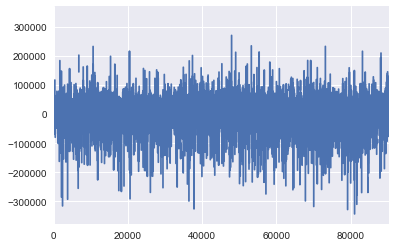

In [29]:
r2 = r2_score(ytest, model.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = model.predict(xtest)-ytest

data1['pred_diff'].plot()

In [33]:
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False], 'min_samples_leaf':[1],
               'max_features':['auto', 'sqrt']}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid.fit(xtrain,ytrain)
print("Random Forest MSE:",np.mean(grid.predict(xtest)-ytest)**2)
print("Random Forest MAE:",np.mean(np.abs(grid.predict(xtest)-ytest)))
print("Random Forest RMSE:",sqrt(np.mean(grid.predict(xtest)-ytest)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest MSE: 45399.360553097256
Random Forest MAE: 25444.668226874564
Random Forest RMSE: 213.0712569848342


R2: 0.8778


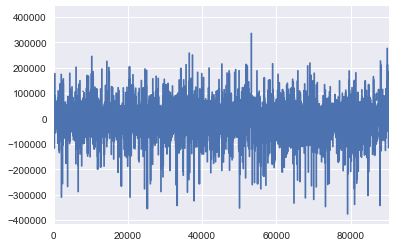

In [35]:
r2 = r2_score(ytest, grid.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid.predict(xtest)-ytest

data1['pred_diff'].plot()

In [36]:
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=500000) & (data['taxvaluedollarcnt']<10000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False], 'min_samples_leaf':[1],
               'max_features':['auto', 'sqrt']}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid.fit(xtrain,ytrain)
print("Random Forest MSE:",np.mean(grid.predict(xtest)-ytest)**2)
print("Random Forest MAE:",np.mean(np.abs(grid.predict(xtest)-ytest)))
print("Random Forest RMSE:",sqrt(np.mean(grid.predict(xtest)-ytest)**2))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest MSE: 777417.8382810638
Random Forest MAE: 75006.91918235208
Random Forest RMSE: 881.713013560004


R2: 0.8547


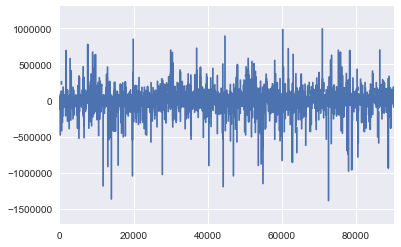

In [37]:
r2 = r2_score(ytest, grid.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid.predict(xtest)-ytest

data1['pred_diff'].plot()

In [38]:
# Gradient Boosting Regression
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<1000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'huber', 'alpha':0.95}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(xtrain,ytrain)
print("GBR MAE:",np.mean(np.abs(clf.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


GBR MAE: 41728.06088807442


R2: 0.8938


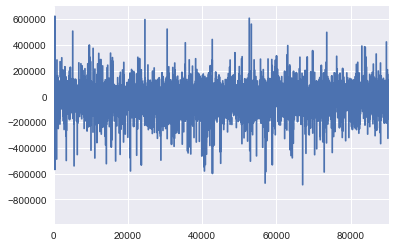

In [39]:
r2 = r2_score(ytest, clf.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = clf.predict(xtest)-ytest

data1['pred_diff'].plot()

In [55]:
# Gradient Boosting Regression
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<1000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'huber', 'alpha':0.95}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(xtrain,ytrain)
print("GBR MAE:",np.mean(np.abs(clf.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


GBR MAE: 55119.29501092173


R2: 0.9126


C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


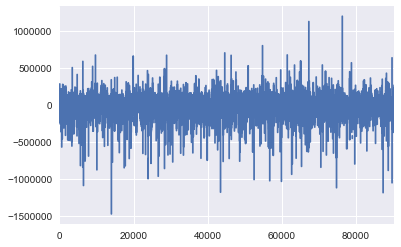

In [56]:
r2 = r2_score(ytest, clf.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = clf.predict(xtest)-ytest

data1['pred_diff'].plot()

In [40]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.3,
                    max_depth = 5,
                    )
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 58955.44629568971


In [45]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 1)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 49474.62057502539


In [49]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 2)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 49229.155988089246


In [53]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 5)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 48349.732413980884


R2: 0.9228


C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


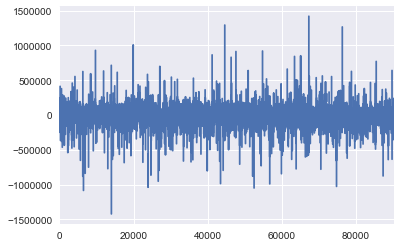

In [54]:
r2 = r2_score(ytest, model.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = model.predict(xtest)-ytest

data1['pred_diff'].plot()

In [51]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 10)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


XGBoost MAE: 48649.498832841404


R2: 0.9233


C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


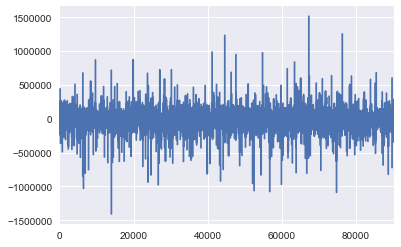

In [52]:
r2 = r2_score(ytest, model.predict(xtest))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = model.predict(xtest)-ytest

data1['pred_diff'].plot()